In [1]:
import tensorflow as tf 
import numpy as np
import PIL
import PIL.Image
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

import concept_gated_conv

2023-07-04 16:16:47.498936: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-07-04 16:16:49.649070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 16:16:49.665497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 16:16:49.665699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

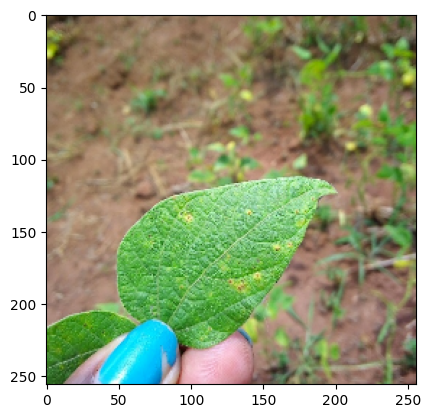

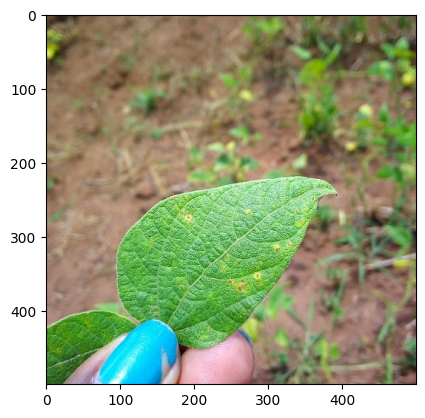

In [2]:
# loading the dataset
def bean_img_iter(bs = 32):
    img_size = (500, 500)
    
    dataset = tfds.load("beans", split='train', shuffle_files=True)
    dataset = dataset.batch(bs, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return iter(dataset)

dsIter = bean_img_iter()
ds = next(dsIter)
dsImages = tf.image.resize(ds['image'], (256, 256)) 
# print(dsImages.shape)
# print(dsImages)


plt.imshow(tf.cast(dsImages[1], dtype=tf.uint8))
plt.show()

plt.imshow(ds['image'][1])
plt.show()

